<a href="https://colab.research.google.com/github/PoKai-H/Dog-Breed-Prediction/blob/master/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Keras and Tensorflow to build train and test a convolutional neural network capable of identifying the breed of a dog in a supplied image<br><br>
1.Loading the data from kaggle to colab<br>
2.load labels csv for labels that contain image ID and Breed<br>
3.Checking the breed Count<br>
4.One-Hot encoding on labels data prediction column<br>
5.load the images, convert them to an array, and normalize them<br>
6.Check the shape abd size of the x and y data<br>
7.Building the model network architecture<br>
8.Split the data and fit it into the mofel and create an accuracy plot<br>
9.Evaluate the model for accuracy score<br>
10.Using the model for prediction<br>

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"pokaihuang31","key":"b855894f89dda42bb800e2a6fba16729"}'}

In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API

In [7]:
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [8]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1696          6  0.1764706        


Searching Kaggle for the required dataset using search options with title 'dogbreedidfromcomp'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [9]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 96% 666M/691M [00:02<00:00, 297MB/s]
100% 691M/691M [00:02<00:00, 279MB/s]
/content


In [10]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip


Archive:  dog_dataset/dogbreedidfromcomp.zip
replace dog_dataset/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dog_dataset/labels.csv  
replace dog_dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: dog_dataset/sample_submission.csv  
replace dog_dataset/test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace dog_dataset/test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [y]
error:  invalid response [[y]]
replace dog_dataset/test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [61]:
#Import Libary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# from keras.optimizers import Adam does not work
from tensorflow.keras.optimizers import Adam


In [62]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head(10) #show first five rows

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


10222 rows and 2 colums (id, breed)

In [63]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
print(breeds_all)
breed_counts = breeds_all.value_counts()
breed_counts.head(10) 

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

Here we are finding out the count per class i.e. total data in each class using value_counts() function.

In [64]:
# Selecting first 5 breeds (Limitation due to computation power)
CLASS_NAMES = list(breeds_all[0:5])
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,2,001cdf01b096e06d78e9e5112d419397,pekinese
3,3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [65]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32') # np.zeros (圖片個數, size(x), size(y), rgb3colors)
# One hot coding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES) # (圖片個數, 5個class)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' %labels['id'][i], target_size=(224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x/255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ' ,X_data.shape, 'size:{:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape, 'size:{:,}'.format(Y_data.size)) 

100%|██████████| 394/394 [00:01<00:00, 218.64it/s]


Train Images shape:  (394, 224, 224, 3) size:59,308,032
One-hot encoded output shape:  (394, 5) size:1,970


One-Hot coding <br>
很多機器學習任務中, 特徵並不總是連續值, 有可能是分類值
如果特徵用數字表示, 效率會高很多, 但是轉化為數字後, 上述的數據就不能直接用在分類器中。因為分類器往往默認數據是連續並且有排序,但特徵用數字表示後是隨機分配的。<br><br>
解决上述问题的一种方法是采用One-Hot Encoding。

独热编码，又称一位有效编码，其方法是使用N位状态寄存器来对N个状态进行编码，每个状态都有它独立的寄存器位，并且在任意时候，其中只有一位有效。
可以这样理解，对于每一个特征，如果它有m个可能值，那么经过独热编码后，就变成了m个二元特征。并且，这些特征互斥，每次只有一个激活。因此，数据会变成稀疏的。

这样做的好处主要有：

1.解决了分类器不好处理属性数据的问题

2.在一定程度上也起到了扩充特征的作用



In [72]:
# Using CNN to build Model
model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5), activation='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters = 48, kernel_size = (3,3), activation='relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation='relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation='relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation='relu', kernel_regularizer= 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(64, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(32, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 108, 108, 48)      27696     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 54, 54, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 50, 50, 32)        38432     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 25, 25, 32)      

Nest we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d(It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor),max_pooling2d(It is a downsampling technique which takes out the maximun value over the window defined by poolsize), flatten(It flattens the input and creates a 1D output),Dense(Dense layer produce the output as the output as the dot product of input and kernel).

In [73]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data,Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

Now we train our model on 100 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

In [74]:
# Training the model
epochs = 300
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val))

Epoch 1/300
3/3 [==============================] - 2s 387ms/step - loss: 4.6352 - accuracy: 0.1979 - val_loss: 4.6193 - val_accuracy: 0.1268
Epoch 2/300
3/3 [==============================] - 1s 254ms/step - loss: 4.6106 - accuracy: 0.2226 - val_loss: 4.5958 - val_accuracy: 0.1549
Epoch 3/300
3/3 [==============================] - 1s 251ms/step - loss: 4.5868 - accuracy: 0.2403 - val_loss: 4.5722 - val_accuracy: 0.1268
Epoch 4/300
3/3 [==============================] - 1s 252ms/step - loss: 4.5633 - accuracy: 0.2650 - val_loss: 4.5489 - val_accuracy: 0.1549
Epoch 5/300
3/3 [==============================] - 1s 246ms/step - loss: 4.5401 - accuracy: 0.2438 - val_loss: 4.5273 - val_accuracy: 0.1549
Epoch 6/300
3/3 [==============================] - 1s 252ms/step - loss: 4.5175 - accuracy: 0.2403 - val_loss: 4.5052 - val_accuracy: 0.1549
Epoch 7/300
3/3 [==============================] - 1s 251ms/step - loss: 4.4944 - accuracy: 0.2367 - val_loss: 4.4817 - val_accuracy: 0.1549
Epoch 8/300
3

Here we analyse how the model is learing with each epoch in terms of accuracy.

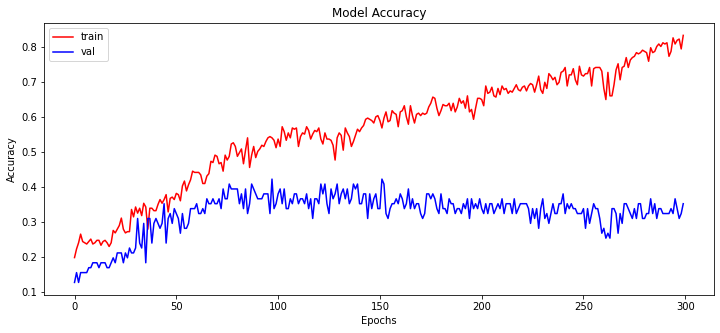

In [75]:
# Plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])

plt.show()

We will use predict function to make predictions using this model also we are finding out the accuracy on the test set

In [76]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ',round((score[1]*100),2),'%')

2/2 [==============================] - 0s 16ms/step - loss: 2.6627 - accuracy: 0.5250
Accuracy over the test set: 
  52.5 %


Image with original and prediction label 

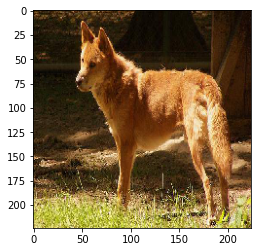

Originally :  dingo
Predicted :  pekinese


In [77]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from prediction list and comparing original value vs predicted
print('Originally : ',labels['breed'][np.argmax(Y_test[1])])
print('Predicted : ',labels['breed'][np.argmax(Y_pred[1])])

In [78]:
model.save('dogbreed.h5')